# Bank customers churn prediction

importing necessary modules

In [81]:
# pip install xgboost

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

reading dataset from csv file

In [83]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Our dataset have 10K rows and 14 columns. Each columns have no null values as we observe below.

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Split feature and Target columns

In [85]:
X = df.drop(columns=['Exited'])#Feature variables
y = df['Exited']
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

Checking Low or High cardinality and removing columns with cardinality issue since cardinal columns doesnt used for prediction feature extraction.

In [86]:
for column in X.columns:
    print(f'{column}: {df[column].nunique()}' )

RowNumber: 10000
CustomerId: 10000
Surname: 2932
CreditScore: 460
Geography: 3
Gender: 2
Age: 70
Tenure: 11
Balance: 6382
NumOfProducts: 4
HasCrCard: 2
IsActiveMember: 2
EstimatedSalary: 9999


In [87]:
# Drop high cardinal columns [RowNumber, CustomerId, Surname]
X.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


Lets use boxplot and histogram to see distribution of features

**Observations from plot**  
- CreditScore has outliers on the left side while data is symetrical
- Age has outliers on the right side while data is symetrical
- Balance looks left skewed with no outlier

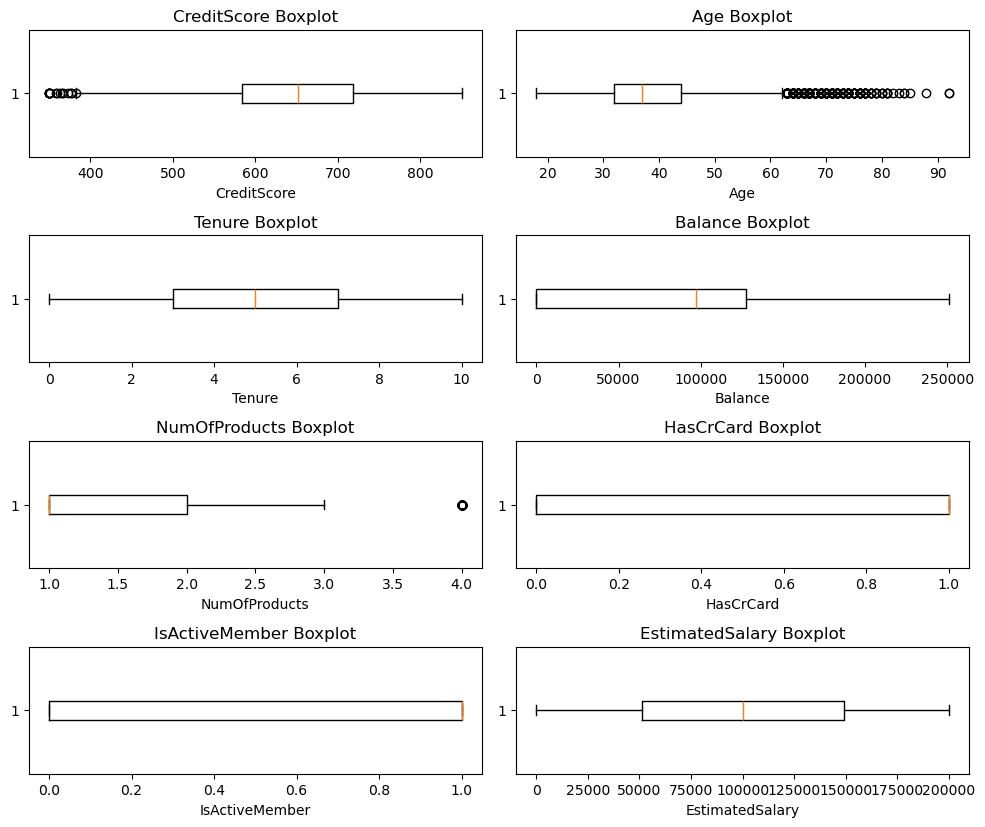

In [88]:
numeric_columns = X.select_dtypes(include=['number'])

plt.figure(figsize=(10, 10))
for index, column in enumerate(numeric_columns.columns):
    ax = plt.subplot(5, 2, index + 1)
    plt.boxplot(numeric_columns[column], vert=False)
    plt.title(f'{column} Boxplot')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

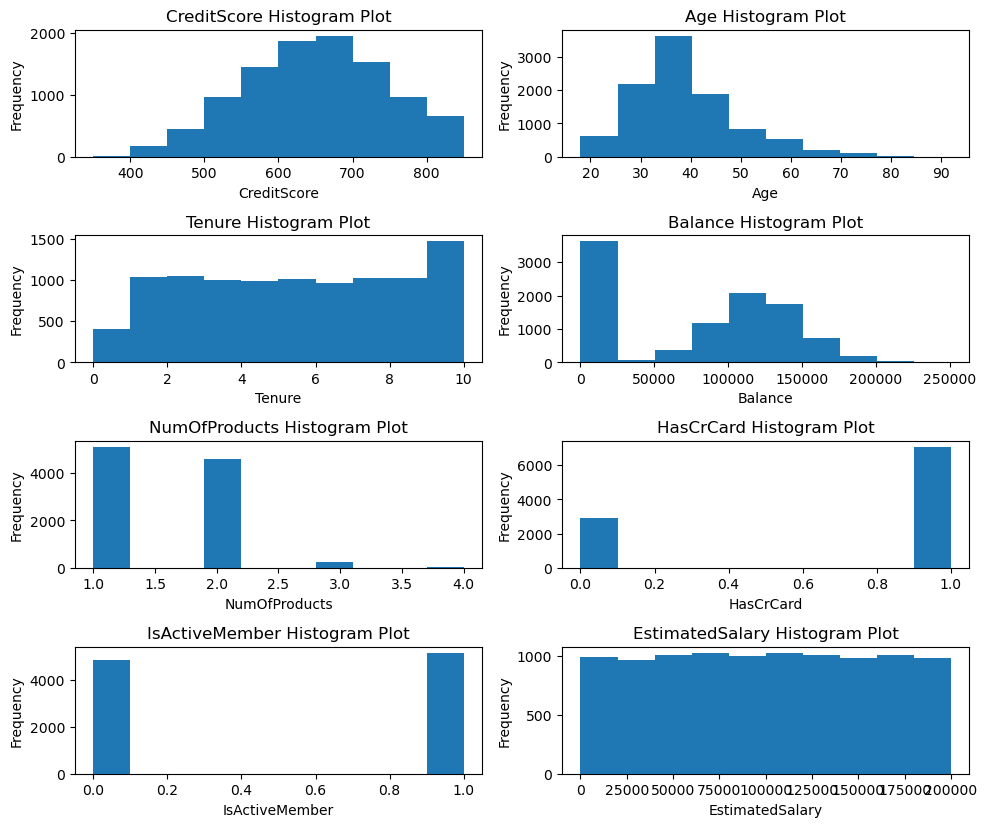

In [89]:
plt.figure(figsize=(10, 10))
for index, column in enumerate(numeric_columns.columns):
    ax = plt.subplot(5, 2, index + 1)
    plt.hist(numeric_columns[column])
    plt.title(f'{column} Histogram Plot')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [90]:
def calculate_age_group_balance(df):
    df['age_group'] = pd.cut(df['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle-aged', 'Senior'])
    return df.groupby('age_group')['Balance'].mean()

def count_customers_by_country(df):
    return df['Geography'].value_counts().to_dict()

# Example usage:
avg_balance_by_age = calculate_age_group_balance(df)
customers_by_country = count_customers_by_country(df)


C:\Users\user\AppData\Local\Temp\ipykernel_13148\1097480910.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('age_group')['Balance'].mean()


In [91]:
avg_balance_by_age

age_group
Young          73198.764050
Middle-aged    76795.899418
Senior         79951.380071
Name: Balance, dtype: float64

In [92]:
customers_by_country

{'France': 5014, 'Germany': 2509, 'Spain': 2477}

Filter top 10 High-Value Customers

Feature Engineering

In [93]:
high_value_customers = [customer_id for customer_id, balance in zip(df['CustomerId'], df['Balance']) if balance > 100000]
high_value_customers[:10]

[15619304,
 15737888,
 15574012,
 15656148,
 15792365,
 15592389,
 15767821,
 15643966,
 15737452,
 15736816]

In [94]:
df['balance_per_product'] = df['Balance'] / df['NumOfProducts']
df['is_high_value'] = df['Balance'] > df['Balance'].mean()



In [95]:
df[['balance_per_product','is_high_value']].head()

,balance_per_product,is_high_value
0,0.000000,False
1,83807.860000,True
2,53220.266667,True
3,0.000000,False
4,125510.820000,True


**Convert Categorical Variables**
- Convert categorical features to numerical using pd.get_dummies

In [96]:
X = pd.get_dummies(X, columns=['Gender', 'Geography'], drop_first=True)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,False,False,True
2,502,42,8,159660.80,3,1,0,113931.57,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,False,False,True


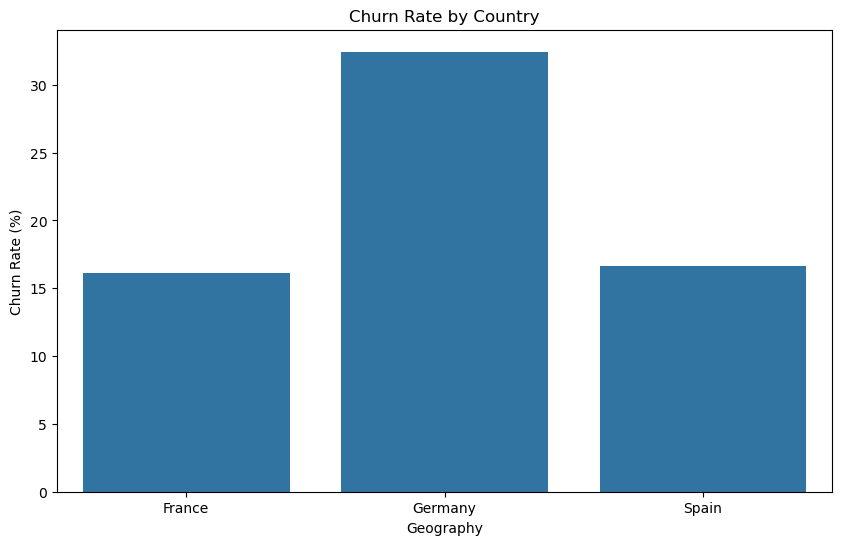

In [97]:
plt.figure(figsize=(10, 6))
churn_rate_by_country = df.groupby('Geography')['Exited'].mean() * 100
sns.barplot(x=churn_rate_by_country.index, y=churn_rate_by_country.values)
plt.title('Churn Rate by Country')
plt.ylabel('Churn Rate (%)')
plt.show()


Train-Test Split 80 percent for traning and 20 for test

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

Model Training

In [99]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Model Evaluation

In [100]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_train))
print("Classification Report:\n", classification_report(y_train, y_train))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6365
           1       1.00      1.00      1.00      1635

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [101]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7845
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88      1598
           1       0.30      0.05      0.09       402

    accuracy                           0.78      2000
   macro avg       0.55      0.51      0.49      2000
weighted avg       0.70      0.78      0.72      2000



Train XGBoost 

In [102]:
xgb_model = XGBClassifier(
    n_estimators=100,         
    learning_rate=0.1,        
    max_depth=4,              
    subsample=0.8,            
    colsample_bytree=0.8,     
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Evaluate XGBoost

On training dataset

In [103]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_train)
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_train, y_train))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6365
           1       1.00      1.00      1.00      1635

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



On test dataset

In [104]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.864
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1598
           1       0.75      0.48      0.59       402

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



As we obsevered above both LogisticRegression and XGBoost performs well on training dataset whereas XGBoost outperforms on test dataset